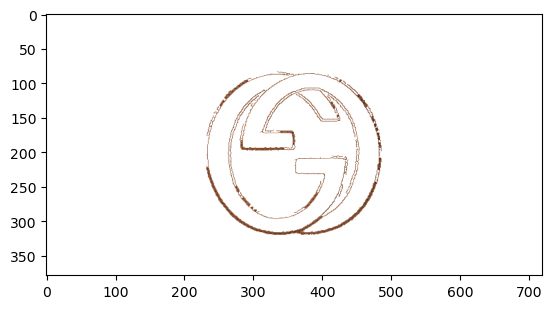

In [112]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def segment_logo(image_path, background_color=(255, 255, 255)):
    # Load the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 50, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming largest contour is the logo (This might not always be the case)
    # Sort contours by area and get the largest
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    # Create an empty mask
    mask = np.zeros_like(gray)

    # Draw the contour on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Create a solid color image for background
    background = np.full_like(img, background_color, dtype=np.uint8)

    # Apply the mask to the original image
    result = np.where(mask[..., None].astype(bool), img, background)

    return result

# This is a placeholder since we need an actual image path.
# Replace 'path_to_handbag_image.jpg' with the actual image path.
segmented_logo = segment_logo('./test/original/handbag3.jpg')

# Displaying the result (this will not work in this text-only environment)
# but in a Python environment, you can use:
plt.imshow(cv2.cvtColor(segmented_logo, cv2.COLOR_BGR2RGB))
plt.show()


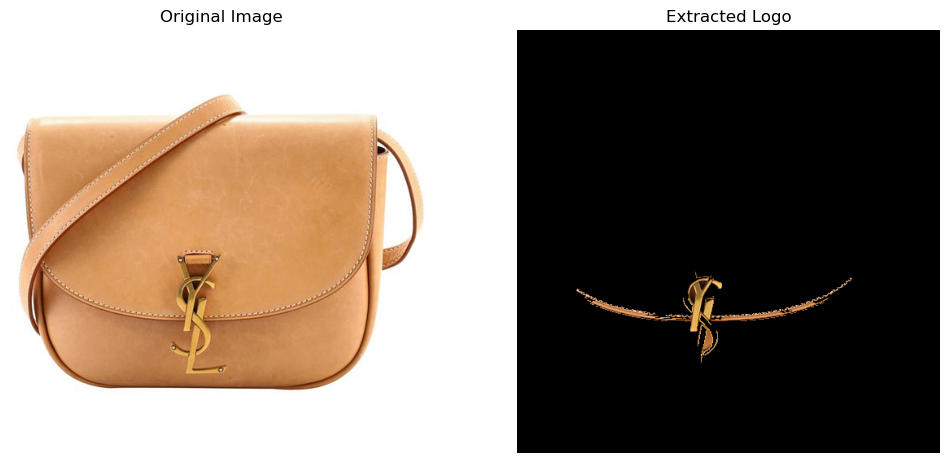

In [171]:
from skimage import io, color, filters, morphology, measure
import matplotlib.pyplot as plt
import numpy as np

# For the sake of example, let's assume we have a sample image loaded
# Since we cannot load external images directly, replace 'sample_image.jpg' with the actual image file path
image_path = './test/original/handbag7.jpg'  # Placeholder for user-provided image path

# Load the image using scikit-image
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

# Enhance edges using the Sobel filter
edges = filters.sobel(gray_image)

# Apply a threshold to get a binary image
threshold_value = filters.threshold_otsu(edges)
binary_mask = edges > threshold_value

# Perform morphological operations to remove small objects and clean up the mask
cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=450)  # min_size can be adjusted
cleaned_mask = morphology.remove_small_holes(cleaned_mask, area_threshold=460)  # area_threshold can be adjusted

# Label the image
labeled_image = measure.label(cleaned_mask)

# Assume the largest object is the logo (this may need to be adjusted)
regions = measure.regionprops(labeled_image)
largest_region = max(regions, key=lambda r: r.area)

# Create a mask for the largest object
logo_mask = np.zeros_like(gray_image, dtype=bool)
for coord in largest_region.coords:
    logo_mask[coord[0], coord[1]] = True

# Apply the mask to the original image to extract the logo
logo = image.copy()
for i in range(3):  # Assuming image has 3 color channels
    logo[:, :, i] = logo[:, :, i] * logo_mask

# Display the original image and the extracted logo side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Extracted logo
ax[1].imshow(logo)
ax[1].set_title('Extracted Logo')
ax[1].axis('off')

plt.show()


In [114]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# # Load your image
# image = io.imread('./test/original/handbag1.jpg')  # Replace with the path to your image

# # If the image is not in grayscale, convert it
# gray_image = color.rgb2gray(image) if len(image.shape) == 3 else image

# # Rest of your code
# thresh = threshold_otsu(gray_image)
# print(thresh)
# bw = closing(gray_image > thresh, square(3))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)
# plt.show()


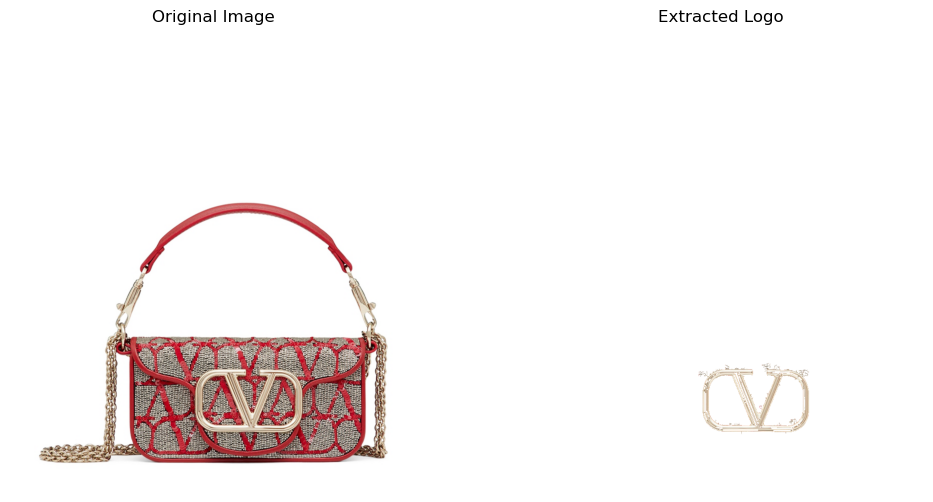

In [147]:
def segment_logo_skimage(image):
    # Apply Otsu's thresholding
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    thresh = threshold_otsu(gray_image)
    bw = closing(gray_image > thresh, square(2))

    # Remove artifacts connected to image border
    cleared = clear_border(bw)

    # Label image regions
    label_image = label(cleared)

    # Find the logo region
    regions = regionprops(label_image)
    logo_region = max(regions, key=lambda r: r.area)  # Assuming the logo is the largest region

    # Create a mask for the logo
    logo_mask = np.zeros_like(gray_image)
    minr, minc, maxr, maxc = logo_region.bbox
    logo_mask[minr:maxr, minc:maxc] = label_image[minr:maxr, minc:maxc] == logo_region.label

    # Extract the logo from the original image
    logo = np.zeros_like(image)
    for i in range(3):  # for each color channel
        logo[:, :, i] = image[:, :, i] * logo_mask

    # Change background to a solid color (e.g., white)
    background_color = [255, 255, 255]  # White background
    for i in range(3):  # for each color channel
        logo[:, :, i][logo_mask == 0] = background_color[i]

    return logo

image = cv2.imread('./test/original/handbag8.jpeg')
logo = segment_logo_skimage(image)
# Display the original image and the extracted logo side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
logo = cv2.cvtColor(logo, cv2.COLOR_BGR2RGB)
# Original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Extracted logo
ax[1].imshow(logo)
ax[1].set_title('Extracted Logo')
ax[1].axis('off')

plt.show()

# Data

In [ ]:
import json
import os
import cv2
import numpy as np

# Load VIA JSON annotations
with open('./via_project_14Dec2023_11h31m.json') as json_file:
    annotations = json.load(json_file)

def create_mask_from_via(via_annotation, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for region in via_annotation['regions']:
        shape_attributes = region['shape_attributes']
        if shape_attributes['name'] == 'circle':
            cv2.circle(mask, (shape_attributes['cx'], shape_attributes['cy']),
                       shape_attributes['r'], 255, -1)
        elif shape_attributes['name'] == 'polyline' or shape_attributes['name'] == 'polygon':
            pts = np.array(list(zip(shape_attributes['all_points_x'], shape_attributes['all_points_y'])), np.int32)
            cv2.fillPoly(mask, [pts], 255)
        elif shape_attributes['name'] == 'rect':
            cv2.rectangle(mask, (shape_attributes['x'], shape_attributes['y']),
                          (shape_attributes['x'] + shape_attributes['width'],
                           shape_attributes['y'] + shape_attributes['height']), 255, -1)
        # Add other shapes if necessary
    return mask

# Directory where the images are stored
image_dir = './temp/clean/'

for image_id, via_annotation in annotations['_via_img_metadata'].items():
    image_filename = via_annotation['filename']
    image_path = os.path.join(image_dir, image_filename)

    # Load image to get the shape
    image = cv2.imread(image_path)
    mask = create_mask_from_via(via_annotation, image.shape)

    # Save mask to file or use it directly for training your model
    mask_filename = os.path.splitext(image_filename)[0] + '.png'
    mask_path = os.path.join('./temp/masks/', mask_filename)
    cv2.imwrite(mask_path, mask)


# Machine Learning

In [ ]:
import matplotlib.pyplot as plt

def show_image_mask_batch(image_batch, mask_batch):
    batch_size = len(image_batch)
    plt.figure(figsize=(10, 4 * batch_size))

    for i in range(batch_size):
        plt.subplot(batch_size, 2, 2*i + 1)
        plt.imshow(image_batch[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 2, 2*i + 2)
        plt.imshow(mask_batch[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

# Define data directories and paths
train_data_dir = "./train/images"
train_mask_dir = "./train/masks"
val_data_dir = "./validation/images"
val_mask_dir = "./validation/masks"

# Define image dimensions and number of channels
img_height = 256
img_width = 256
num_channels = 3

class ImageMaskGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_height, img_width, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_filenames))
        batch_filenames = self.image_filenames[start:end]

        batch_size = len(batch_filenames)  # Adjust batch size for last batch
        images = np.empty((batch_size, self.img_height, self.img_width, 3))
        masks = np.empty((batch_size, self.img_height, self.img_width, 1))

        for i, filename in enumerate(batch_filenames):
            img_path = os.path.join(self.image_dir, filename)
            mask_path = os.path.join(self.mask_dir, filename)

            image = cv2.imread(img_path)
            image = cv2.resize(image, (self.img_width, self.img_height))
            images[i,] = image / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                continue  # Consider how to handle this case
            mask = cv2.resize(mask, (self.img_width, self.img_height))
            masks[i,] = np.expand_dims(mask, axis=-1) / 255.0

        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Generate data batches for training and validation
# Initialize generators
train_generator = ImageMaskGenerator(train_data_dir, train_mask_dir, 16, img_height, img_width)
val_generator = ImageMaskGenerator(val_data_dir, val_mask_dir, 8, img_height, img_width)


# Define U-Net model
inputs = Input(shape=(img_height, img_width, num_channels))

# Encoder path
down1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
down1 = Conv2D(64, (3, 3), activation='relu', padding='same')(down1)
pool1 = MaxPooling2D((2, 2))(down1)

down2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
down2 = Conv2D(128, (3, 3), activation='relu', padding='same')(down2)
pool2 = MaxPooling2D((2, 2))(down2)

down3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
down3 = Conv2D(256, (3, 3), activation='relu', padding='same')(down3)
pool3 = MaxPooling2D((2, 2))(down3)

down4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
down4 = Conv2D(512, (3, 3), activation='relu', padding='same')(down4)

# Decoder path
up1 = UpSampling2D((2, 2))(down4)
up1 = Concatenate()([up1, down3])
up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)

up2 = UpSampling2D((2, 2))(up1)
up2 = Concatenate()([up2, down2])
up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)

up3 = UpSampling2D((2, 2))(up2)
up3 = Concatenate()([up3, down1])
up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
            
# # Train the model
# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=len(val_generator)
# )

# # Save the trained model
# model.save("trained_unet_model.h5")


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


def segment_logo(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))  # Resize to match the model's input size
    image_normalized = image / 255.0       # Normalize the image
    image_expanded = np.expand_dims(image_normalized, axis=0)

    # Predict the mask
    predicted_mask = model.predict(image_expanded)[0]

    # Convert the predicted mask to a binary mask
    binary_mask = (predicted_mask > 0.3).astype(np.uint8)

    # Post-process the binary mask (optional)
    # binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))

    # Overlay the mask on the original image
    segmented_image = image * np.repeat(binary_mask, 3, axis=-1)

    # Display the segmented image
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()

    # Optionally, save the segmented image
    # cv2.imwrite('segmented_logo.jpg', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Load the trained model
model = load_model('trained_unet_model.h5')

# Segment logo on a new image
segment_logo('./test/handbag1.jpg', model)
